In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
project_root = os.path.dirname(os.getcwd())
data_path = os.path.join(project_root,'data')
interim_path = data_path + '/interim'
data = interim_path + '/datos.csv'
df = pd.read_csv(data)

processed_path = data_path +'/processed'

# Preprocessing

## Normalización o estandarización

In [3]:
df.iloc[:, -3:] = (df.iloc[:, -3:] - df.iloc[:, -3:].mean()) / df.iloc[:, -3:].std()

In [4]:
df

,Unnamed: 0,id_person,activity,timestamp,x,y,z
0,966746,1,Downstairs,"17-03-1970, 20:15:42",-0.118684,0.280806,-0.157985
1,966747,1,Downstairs,"17-03-1970, 20:16:32",-0.080722,0.286735,0.494081
2,966748,1,Downstairs,"17-03-1970, 20:17:22",-0.689566,0.021401,0.759115
3,966749,1,Downstairs,"17-03-1970, 20:18:12",-0.515819,0.099964,0.588736
4,966750,1,Downstairs,"17-03-1970, 20:19:02",-0.124524,0.412732,0.927390
...,...,...,...,...,...,...,...
1098204,231259,36,Walking,"04-06-1970, 17:38:12",-0.420916,-0.138689,1.056650
1098205,231260,36,Walking,"04-06-1970, 17:39:02",-0.543560,-0.229110,1.194168
1098206,231261,36,Walking,"04-06-1970, 17:39:52",-0.606343,-0.211322,1.131139
1098207,231262,36,Walking,"04-06-1970, 17:40:42",-0.701247,-0.154994,1.162654


## Division en ventanas temporales

### Análisis
1. La frecuencia de muestro, como mi dataset es de sensores a 50hz, 128 datos equivales a 2.56 segundos (128/50 = 2.56).
2. En el reconocimiento de actividades humanas, 128 (2.56s) y 256 (5.12) muestras son las más usadas. Porque ventanas más cortas (<1s) pueden perder contexto y ventanas muy largas (>5s) pueden mezclar actividades distintas.
3. Se suele usar un overlap del 50% para no perder eventos en los bordes de las ventanas.

128 muestras es el estándar para empezar, si las actividades son muy rápidas, probaremos con 64 muestras (1.28s) y si son lentas, probaremos con 256 muestras (5.12s).

In [5]:
# 128 muestras sin overlap
window_size = 128
windows = []
for i in range(0, len(df), window_size):
    if len(df.iloc[i: i+window_size] == window_size):
        windows.append(df.iloc[i:i+window_size])

In [ ]:
# con overlap 50%
step = window_size // 2
windows = []
for i in range(0, len(df)-window_size+1, step):
        windows.append(df.iloc[i:i+window_size])

## Análisis del balance de clases

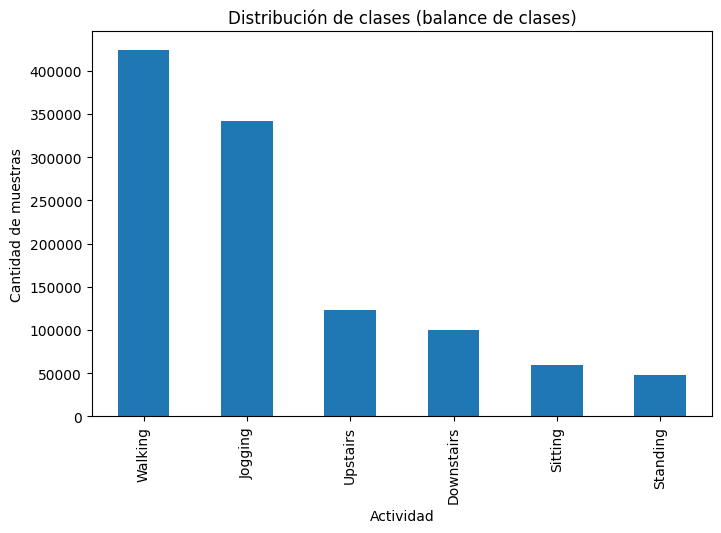

In [6]:
class_counts = df['activity'].value_counts()

plt.figure(figsize=(8, 5))
class_counts.plot(kind='bar')
plt.xlabel('Actividad')
plt.ylabel('Cantidad de muestras')
plt.title('Distribución de clases (balance de clases)')
plt.show()

#  Extracción de características

## Estadísticas por ventana

In [7]:
import numpy as np
from scipy.stats import entropy, skew, kurtosis

In [30]:
def extract_window_features(windows):
    feature_list = []
    for window in windows:
        feats = {}
        for axis in ['x', 'y', 'z']:
            series = window[axis]
            feats[f'mean_{axis}'] = series.mean()
            feats[f'var_{axis}'] = series.var()
            feats[f'skew_{axis}'] = skew(series)
            feats[f'kurtosis_{axis}'] = kurtosis(series)
            feats[f'energy_{axis}'] = np.sum(series**2) / len(series)
            # Entropía basada en histograma
            hist, _ = np.histogram(series, bins=10, density=True)
            feats[f'entropy_{axis}'] = entropy(hist + 1e-12)
        # Etiqueta: la más frecuente en la ventana
        feats['label'] = window['activity'].mode()[0]
        feature_list.append(feats)
    return pd.DataFrame(feature_list)

In [31]:
features_df = extract_window_features(windows)

/tmp/ipykernel_7699/302314006.py:9: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  feats[f'skew_{axis}'] = skew(series)
/tmp/ipykernel_7699/302314006.py:10: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  feats[f'kurtosis_{axis}'] = kurtosis(series)


In [32]:
features_df

,mean_x,var_x,skew_x,kurtosis_x,energy_x,entropy_x,mean_y,var_y,skew_y,kurtosis_y,energy_y,entropy_y,mean_z,var_z,skew_z,kurtosis_z,energy_z,entropy_z,label
0,-0.470215,0.288398,0.378699,0.644527,0.507248,1.867009,0.355466,0.428597,0.229452,-0.604363,0.551604,2.201265,0.268635,0.925778,0.681862,0.007322,0.990710,2.096529,Downstairs
1,-1.275563,0.633436,0.238717,-0.305265,2.255547,2.144883,-0.079222,0.575129,0.166304,-0.609631,0.576912,2.171129,0.114394,0.661184,0.531660,1.123467,0.669105,1.864655,Downstairs
2,-1.366178,0.567709,0.189108,-0.106917,2.429714,2.048567,-0.217066,0.584067,0.406382,-0.678097,0.626622,2.183482,0.097238,0.596212,0.598043,0.807840,0.601009,1.903840,Downstairs
3,-1.430329,0.529991,0.384774,0.206840,2.571691,2.055396,-0.262068,0.465226,0.379390,-0.368356,0.530271,2.076100,0.098470,0.616801,0.635977,0.976240,0.621679,1.902144,Downstairs
4,-1.396508,0.497145,0.414596,0.085174,2.443496,2.078037,-0.267511,0.455613,0.644140,-0.294721,0.523616,2.108096,0.099407,0.559990,0.652242,0.660335,0.565497,1.932747,Downstairs
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8575,-0.230218,0.119226,0.272107,0.222483,0.171295,1.959175,0.394736,0.220722,-0.169524,-0.652572,0.374814,2.223445,0.018282,0.412887,1.396312,2.816103,0.409995,1.717582,Walking
8576,-0.225245,0.098343,0.194295,-0.016344,0.148310,2.049152,0.359507,0.234198,-0.096337,-0.979922,0.361614,2.238524,0.048028,0.498013,1.229989,1.697716,0.496429,1.808183,Walking
8577,-0.206869,0.093957,0.388390,-0.285017,0.136018,2.126799,0.388482,0.235623,-0.075933,-0.803554,0.384701,2.209061,0.066539,0.442961,1.358210,2.370603,0.443928,1.801049,Walking
8578,-0.210861,0.092984,0.311666,0.250665,0.136720,2.048276,0.393056,0.133962,0.118734,-0.516750,0.287408,2.074755,0.046529,0.327358,1.053557,1.643575,0.326965,1.725049,Walking


In [33]:
features_df.to_csv(processed_path+'/features_temporales.csv')

## Transformadas

In [8]:
import pywt

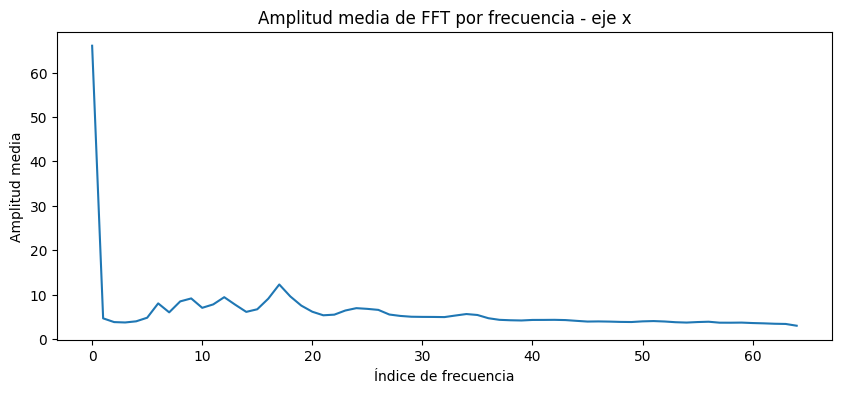

[x] Para cubrir el 90% de la energía, usa K=54


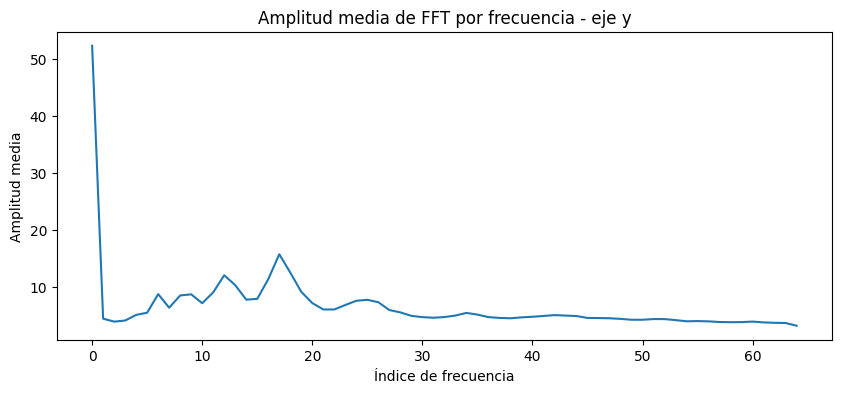

[y] Para cubrir el 90% de la energía, usa K=54


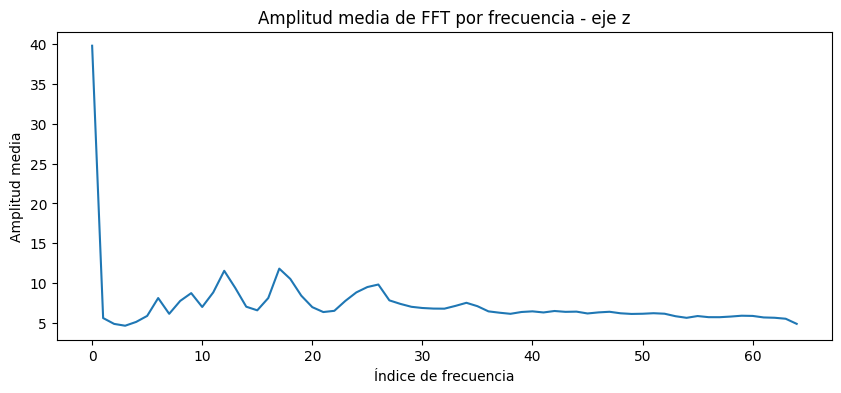

[z] Para cubrir el 90% de la energía, usa K=57


In [10]:
for axis in ['x', 'y', 'z']:
    fft_ampls = []
    for window in windows:
        if len(window) != window_size:
            continue  # skip windows with unexpected length
        serie = window[axis].values.astype(float)
        fft_vals = np.fft.rfft(serie)
        fft_ampls.append(np.abs(fft_vals))
    if not fft_ampls:
        continue  # skip if no valid windows
    fft_ampls = np.stack(fft_ampls)  # ensures 2D array
    mean_fft = fft_ampls.mean(axis=0)

    plt.figure(figsize=(10,4))
    plt.plot(mean_fft)
    plt.title(f"Amplitud media de FFT por frecuencia - eje {axis}")
    plt.xlabel("Índice de frecuencia")
    plt.ylabel("Amplitud media")
    plt.show()

    energy = np.cumsum(mean_fft) / np.sum(mean_fft)
    K = np.argmax(energy >= 0.9) + 1
    print(f"[{axis}] Para cubrir el 90% de la energía, usa K={K}")

/home/flowers/Escritorio/time-series-analysis/finalprojectTS/venv/lib/python3.10/site-packages/pywt/_multilevel.py:43: UserWarning: Level value of 4 is too high: all coefficients will experience boundary effects.
  warnings.warn(


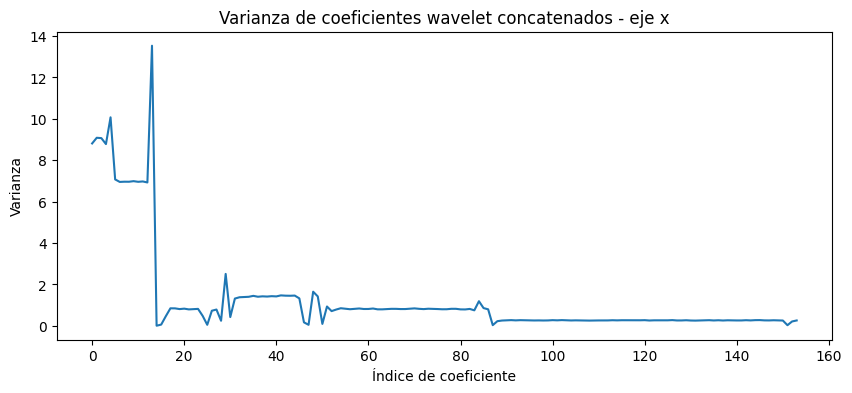

[x] Se seleccionaron 154 coeficientes wavelet con varianza > 0.001


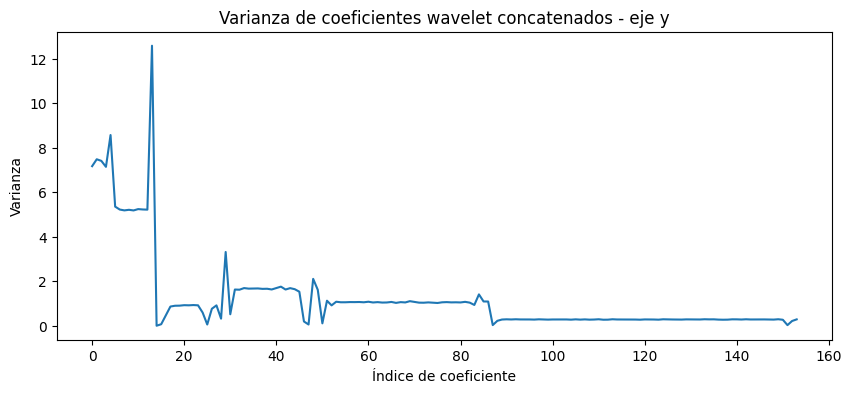

[y] Se seleccionaron 154 coeficientes wavelet con varianza > 0.001


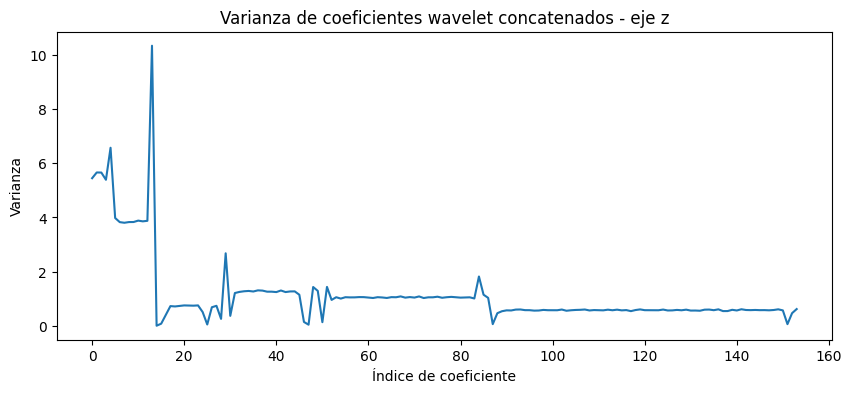

[z] Se seleccionaron 154 coeficientes wavelet con varianza > 0.001


In [12]:
for axis in ['x', 'y', 'z']:
    all_coeffs = []
    for window in windows:
        serie = window[axis].values.astype(float)
        coeffs = pywt.wavedec(serie, 'db4', level=4)
        all_coeffs.append(np.concatenate(coeffs))
    # Pad all arrays to the same length
    maxlen = max(arr.shape[0] for arr in all_coeffs)
    all_coeffs_padded = np.array([np.pad(arr, (0, maxlen - arr.shape[0]), mode='constant') for arr in all_coeffs])

    variances = np.var(all_coeffs_padded, axis=0)
    plt.figure(figsize=(10,4))
    plt.plot(variances)
    plt.title(f"Varianza de coeficientes wavelet concatenados - eje {axis}")
    plt.xlabel("Índice de coeficiente")
    plt.ylabel("Varianza")
    plt.show()

    umbral = 0.001
    selected_idx = np.where(variances > umbral)[0]
    print(f"[{axis}] Se seleccionaron {len(selected_idx)} coeficientes wavelet con varianza > {umbral}")

In [13]:
def extract_spectral_features_windows(windows, fft_k_dict, wavelet_idx_dict):
    features = []
    for window in windows:
        feats = {}
        for axis in ['x', 'y', 'z']:
            serie = window[axis].values.astype(float)
            # FFT
            fft_vals = np.fft.rfft(serie)
            fft_ampl = np.abs(fft_vals)
            fft_freqs = np.fft.rfftfreq(len(serie))
            k = fft_k_dict[axis]
            dom_freqs_idx = np.argsort(fft_ampl)[-k:][::-1]
            dom_freqs = fft_freqs[dom_freqs_idx]
            spectral_energy = np.sum(fft_ampl**2)
            # Wavelet
            coeffs = pywt.wavedec(serie, 'db4', level=4)
            wavelet_coeffs = np.concatenate(coeffs)
            wavelet_idx = wavelet_idx_dict[axis]
            wavelet_coeffs_feat = wavelet_coeffs[wavelet_idx]
            # Guardar features
            for i in range(k):
                feats[f'{axis}_fft_ampl_{i}'] = fft_ampl[i] if i < len(fft_ampl) else 0
                feats[f'{axis}_dom_freq_{i}'] = dom_freqs[i] if i < len(dom_freqs) else 0
            feats[f'{axis}_spectral_energy'] = spectral_energy
            for j, idx in enumerate(wavelet_idx):
                feats[f'{axis}_wavelet_coef_{j}'] = wavelet_coeffs_feat[j] if j < len(wavelet_coeffs_feat) else 0
        # Etiqueta de la ventana
        feats['label'] = window['activity'].mode()[0]
        features.append(feats)
    return pd.DataFrame(features)

In [ ]:
fft_k_dict = {'x': 54, 'y': 54, 'z': 57}
wavelet_idx_dict = {
    'x': np.arange(154),
    'y': np.arange(154),
    'z': np.arange(154)
}

features_df = extract_spectral_features_windows(windows, fft_k_dict, wavelet_idx_dict)